In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics
from schmeud._schmeud import locality as schmeud_locality

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import time
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()
project: signac.Project = signac.get_project(root=config['root'])
project.doc

import gudhi
from gudhi import representations


from skimage import data
import napari

In [2]:
viewer = napari.view_image(data.moon())

In [4]:
# plt.imshow(viewer.screenshot())

In [5]:
# dir(viewer)

In [2]:
def softness_frame(traj, softness_df, frame, n_bins=10, neg=False):

    frames = softness_df["frame"].unique()
    if frame not in frames:
        return None
    
    snap = traj[int(frame)]
    points = snap.particles.position
    points = points[snap.particles.typeid == 0]
    l = snap.configuration.box[0]
    soft = softness_df[softness_df["frame"] == frame]["softness"].values.astype(np.float32)
    if neg:
        soft = -soft
    grid = schmeud_locality.particle_to_grid_cube_cic(points, soft, l, n_bins)

    return grid

In [3]:
n_bins = 30




for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    data = {}
    for idx, job in enumerate(jobs_iter):
        temps = []
        grids = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # if temp > 1.0:
            #     break
            temps.append(temp)
            print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness df
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            grid = softness_frame(traj, softness_df, 0, n_bins=n_bins, neg=True)
            grids.append(grid)
            # break
        # break
        data[idx] = {"temps": temps, "grids": grids}

0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0
0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0
0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0


In [5]:
for temp, grid in zip(data[0]["temps"], data[0]["grids"]):
    viewer.add_image(grid, name=f"{temp:.2f}", colormap="hsv", visible=False)

In [6]:
for image in viewer.layers:
    # image.rendering = "mip"
    image.interpolation3d = "linear"
    image.colormap = "hsv"

In [7]:
for image in viewer.layers:
    image.visible = False
    viewer.reset_view()

In [11]:
viewer.camera.angles

(-13.699744230269548, 40.45024976402553, -21.27386199064651)

In [59]:
for idx, i in enumerate(np.linspace(-180, 180, 120, endpoint=False)):
    # time.sleep(1)
    viewer.camera.angles = (0, i, 30)
    viewer.screenshot(f"/home/ian/Pictures/monk/softness-geometry/sys_cold_temp-0.45_angle-{idx:03d}.png")

In [60]:
import ffmpeg

(
    ffmpeg
    .input('/home/ian/Pictures/monk/softness-geometry/sys_cold_temp-0.45_angle-*.png', pattern_type='glob', framerate=8)
    .output('/home/ian/Pictures/monk/softness-geometry/test-cold-movie.mp4', crf=20)
    .run()
)

# frames = sorted(glob.glob("/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-*.png"))


# process = (
#     ffmpeg
#     .input("pipe:", framerate=2)
#     .output('/home/ian/Pictures/monk/softness-geometry/test-movie.avi', crf=20)
#     .overwrite_output().run_async(pipe_stdin=True)
# )

# for frame in frames:
#     with open(frame, "rb") as f:
#         process.stdin.write(f.read())

# process.stdin.close()

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


(None, None)

/home/ian/Projects/work/monk/.venv/lib/python3.10/site-packages/napari/_qt/widgets/qt_dims.py:294: UserWarning: Refusing to play a hidden axis
  warnings.warn(
[ERROR glean_core] Error setting metrics feature config: Json(Error("EOF while parsing a value", line: 1, column: 0))
[Child 3246599, Main Thread] WARNING: JSWindowActorChild::SendRawMessage (Conduits, ConduitClosed) not sent: !CanSend() || !mManager || !mManager->CanSend(): file /builds/worker/checkouts/gecko/dom/ipc/jsactor/JSWindowActorChild.cpp:57
[Child 3246599, Main Thread] WARNING: JSWindowActorChild::SendRawMessage (Conduits, ConduitClosed) not sent: !CanSend() || !mManager || !mManager->CanSend(): file /builds/worker/checkouts/gecko/dom/ipc/jsactor/JSWindowActorChild.cpp:57
[Child 3246599, Main Thread] WARNING: JSWindowActorChild::SendRawMessage (Conduits, ConduitClosed) not sent: !CanSend() || !mManager || !mManager->CanSend(): file /builds/worker/checkouts/gecko/dom/ipc/jsactor/JSWindowActorChild.cpp:57
[Child 3246599

In [43]:
frames

['/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-0.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-1.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-10.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-11.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-12.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-13.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-14.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-15.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-16.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-17.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-18.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-19.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0.45_angle-2.png',
 '/home/ian/Pictures/monk/softness-geometry/sys_temp-0

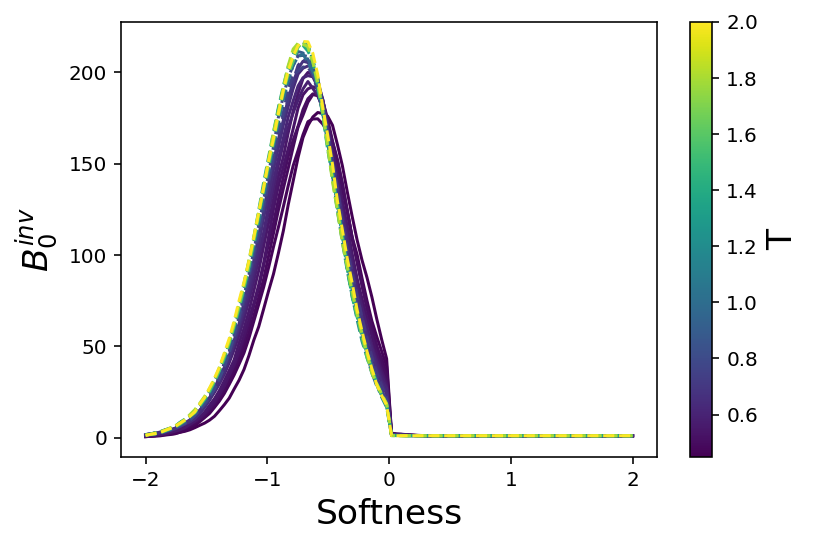

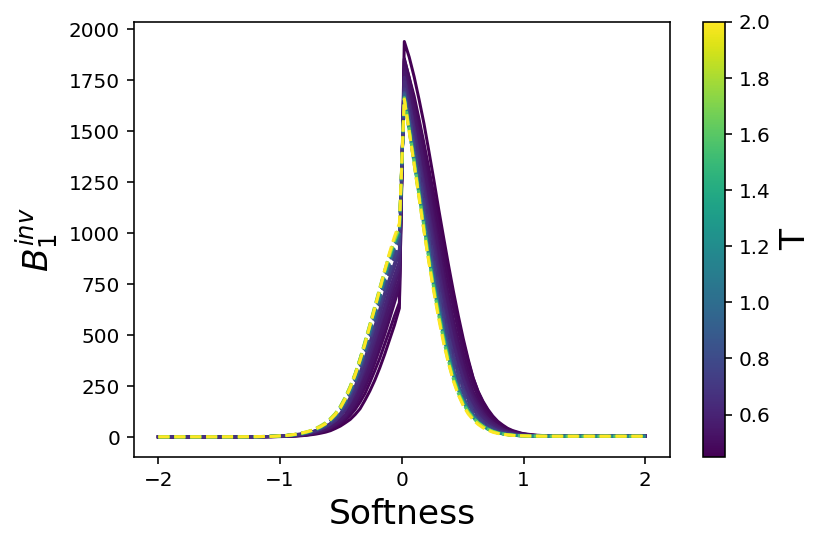

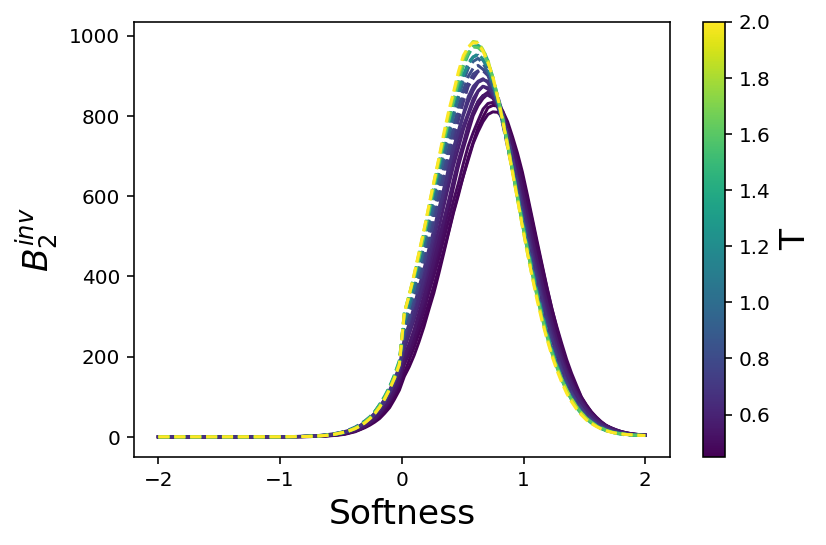

In [7]:
x = np.linspace(-2, 2, 100)
cmap = cm.viridis
norm = colors.Normalize(vmin=np.min(temps), vmax=np.max(temps))
dims = (0, 1, 2)
for dim in dims:
    plt.figure()
    for idx, (curve, temp) in enumerate(zip(betti_curves, temps)):
        m = "-"
        if temp >= 0.7:
            m = "--"
        plt.plot(x, curve[dim], m, label=f"{temp:.2f}", color=cmap(norm(temp)))
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")
    plt.ylabel(fr"$B^{{inv}}_{dim}$")
    plt.xlabel("Softness")
    plt.savefig(f"betti-curve_dim-{dim}_bins-{n_bins}-inv.png", bbox_inches="tight", dpi=150)

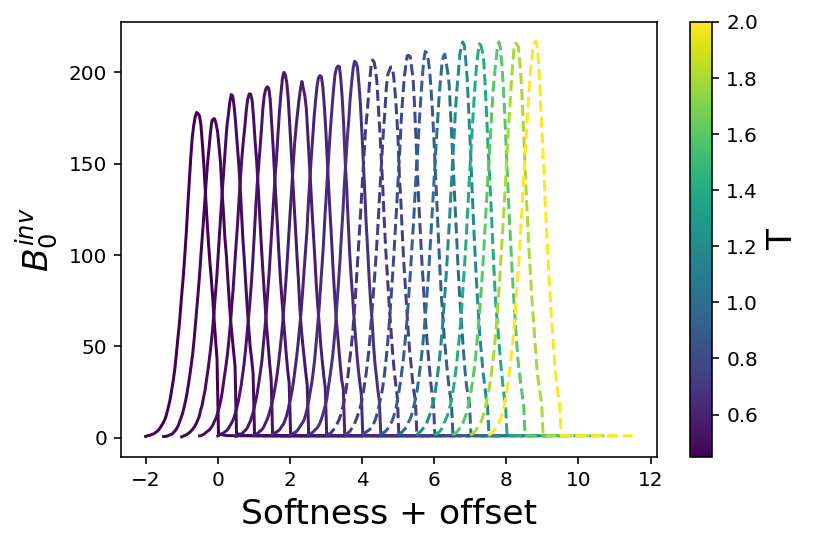

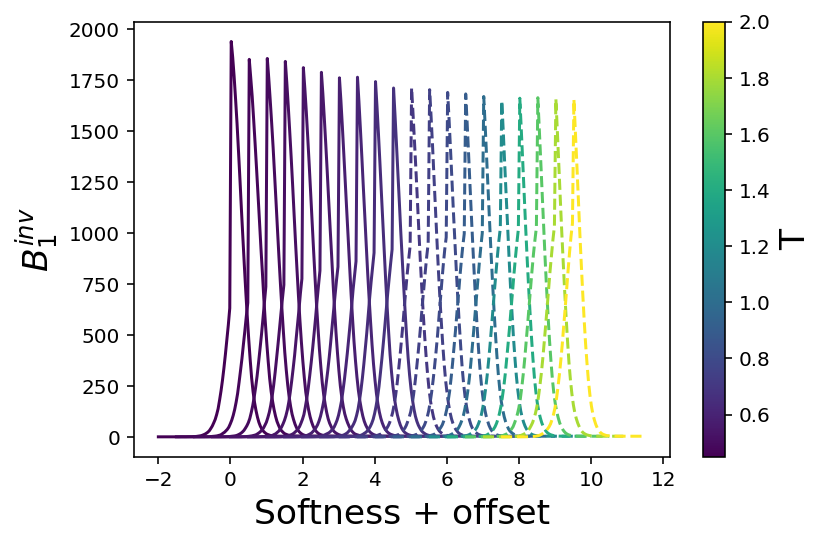

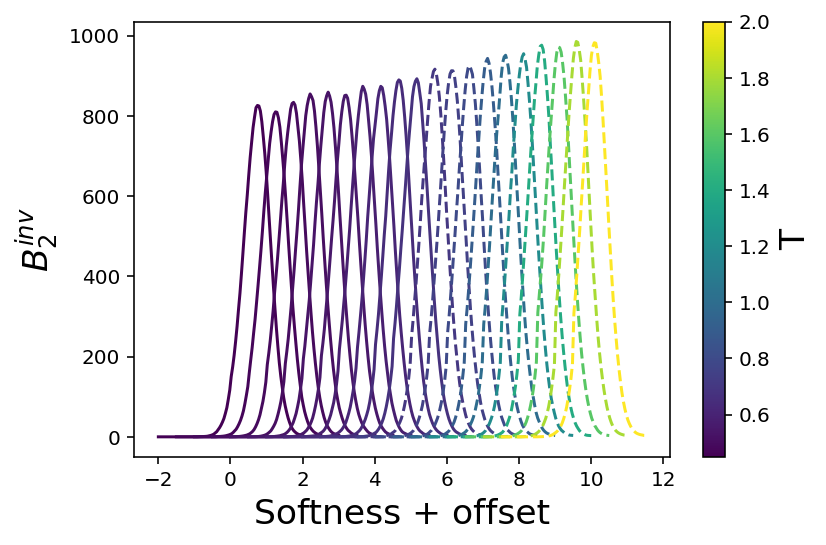

In [8]:
x = np.linspace(-2, 2, 100)
cmap = cm.viridis
norm = colors.Normalize(vmin=np.min(temps), vmax=np.max(temps))
for dim in dims:
    plt.figure()
    for idx, (curve, temp) in enumerate(zip(betti_curves, temps)):
        m = "-"
        if temp >= 0.7:
            m = "--"
        plt.plot(x + idx/2, curve[dim], m, label=f"{temp:.2f}", color=cmap(norm(temp)))
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")
    # plt.legend()
    plt.ylabel(fr"$B^{{inv}}_{dim}$")
    plt.xlabel("Softness + offset")
    plt.savefig(f"betti-curve_dim-{dim}_bins-{n_bins}_offset-inv.png", bbox_inches="tight", dpi=150)

In [14]:
n_bins = 30
b_val = 0.5

for delta, jobs_iter in project.find_jobs({"delta": 0.0}, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job_bettis = []
    for job in jobs_iter:
        betti_curves = []
        temps = []
        for run_dir in sorted(glob.glob(job.fn("short_runs/temp-*"))):
            temp = float(utils.extract_between(run_dir, "temp-", "/"))
            # if temp > 1.0:
            #     break
            temps.append(temp)
            print(temps[-1])
            run_dir = pathlib.Path(run_dir)
            # get softness df
            softness_df = pd.read_parquet(run_dir / "struct-descr.parquet")
            # get traj
            traj = gsd.hoomd.open(run_dir / "traj.gsd")

            betti_curve = compute_betti_curve_w_bmask(traj, softness_df, n_bins=n_bins, dims=(0,1,2), neg=True, b_val=b_val)
            betti_curves.append(betti_curve)
        # break
        job_bettis.append(betti_curves)
    betti_curves = np.mean(job_bettis, axis=0)

0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0
0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0
0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0


In [16]:
b_val = 0.5

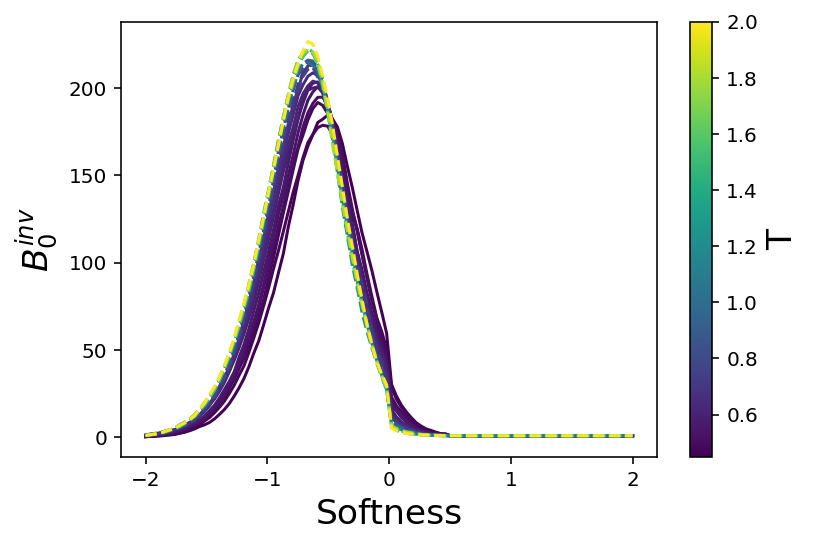

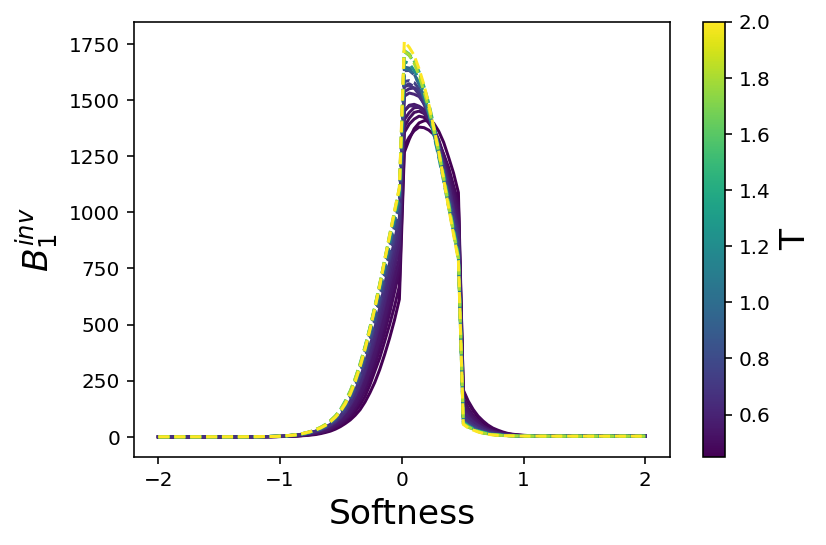

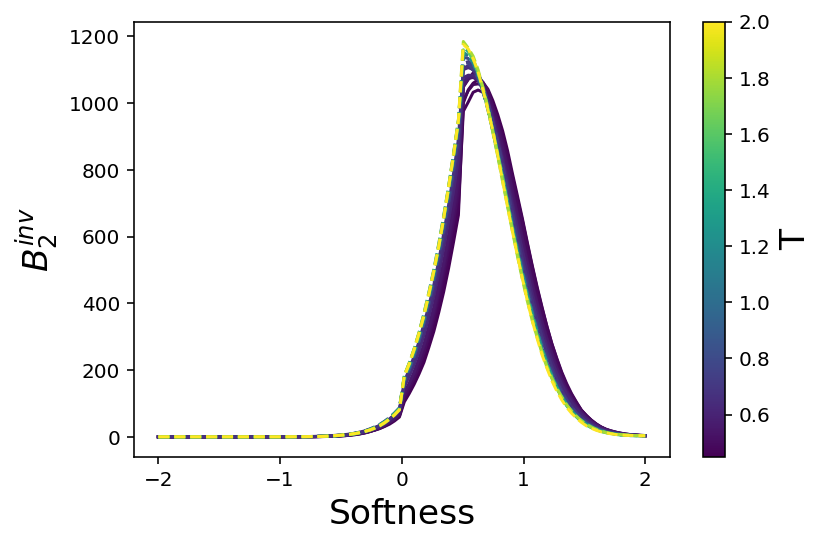

In [17]:
x = np.linspace(-2, 2, 100)
cmap = cm.viridis
norm = colors.Normalize(vmin=np.min(temps), vmax=np.max(temps))
dims = (0, 1, 2)
for dim in dims:
    plt.figure()
    for idx, (curve, temp) in enumerate(zip(betti_curves, temps)):
        m = "-"
        if temp >= 0.7:
            m = "--"
        plt.plot(x, curve[dim], m, label=f"{temp:.2f}", color=cmap(norm(temp)))
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")
    plt.ylabel(fr"$B^{{inv}}_{dim}$")
    plt.xlabel("Softness")
    plt.savefig(f"betti-curve_dim-{dim}_bins-{n_bins}_bmask-{b_val}-inv.png", bbox_inches="tight", dpi=150)

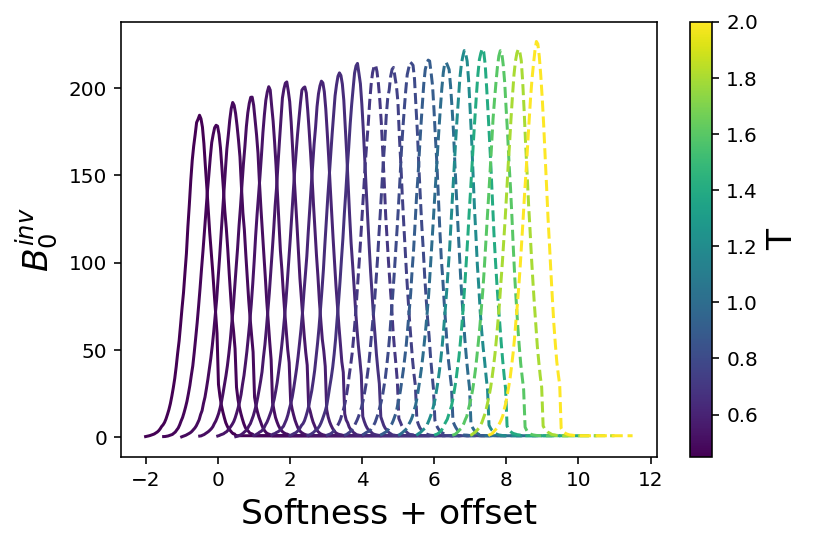

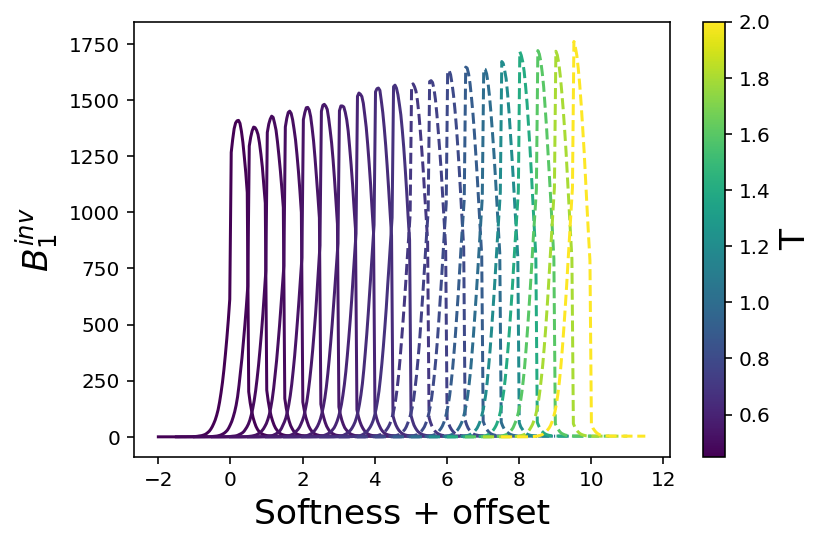

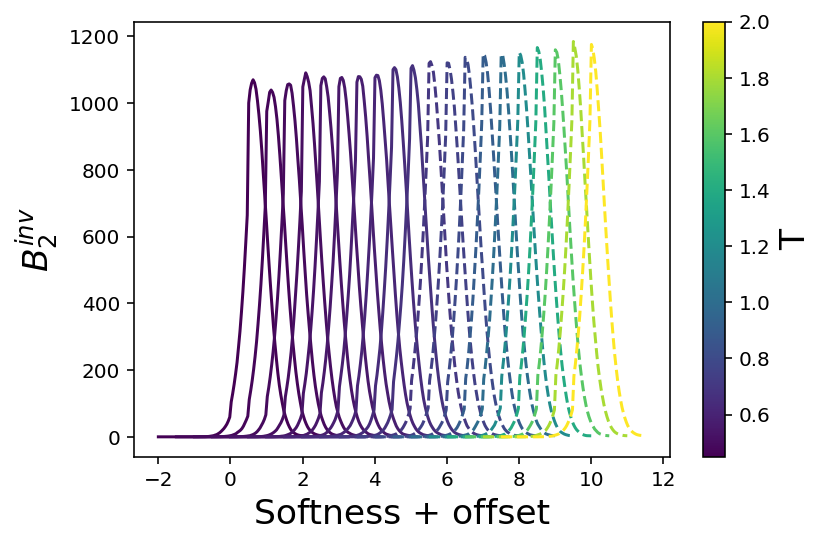

In [18]:
x = np.linspace(-2, 2, 100)
cmap = cm.viridis
norm = colors.Normalize(vmin=np.min(temps), vmax=np.max(temps))
for dim in dims:
    plt.figure()
    for idx, (curve, temp) in enumerate(zip(betti_curves, temps)):
        m = "-"
        if temp >= 0.7:
            m = "--"
        plt.plot(x + idx/2, curve[dim], m, label=f"{temp:.2f}", color=cmap(norm(temp)))
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")
    # plt.legend()
    plt.ylabel(fr"$B^{{inv}}_{dim}$")
    plt.xlabel("Softness + offset")
    plt.savefig(f"betti-curve_dim-{dim}_bins-{n_bins}_bmask-{b_val}_offset-inv.png", bbox_inches="tight", dpi=150)

In [49]:
grid = data[0]["grids"][0]

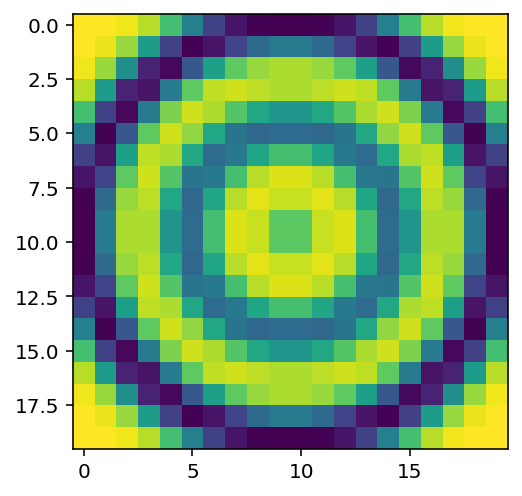

In [26]:
def gauss_2d(kernel_size, sigma=1, muu=0):
 
    # Initializing value of x,y as grid of kernel size
    # in the range of kernel size
 
    x, y = np.meshgrid(np.linspace(-1, 1, kernel_size),
                       np.linspace(-1, 1, kernel_size))
    dst = np.sqrt(x**2+y**2)
 
    # lower normal part of gaussian
    normal = 1/(2.0 * np.pi * sigma**2)
 
    # Calculating Gaussian filter
    gauss = np.exp(-((dst-muu)**2 / (2.0 * sigma**2))) * normal
    return gauss
 
 

N = 20
test_grid = 3 - ( gauss_2d(N, sigma=0.1) + 2.0 * gauss_2d(N, muu=0.5, sigma=0.1) + 3.0 * gauss_2d(N, muu=1.0, sigma=0.1) )
plt.imshow(test_grid)

In [28]:
np.argsort(test_grid).shape

(20, 20)

In [73]:
class Island:

    def __init__(self, site, val):
        self.filt = [(site, val)]
        self.birth = val
        self.juniors = []
        self.elder_site = None


In [86]:
flat_grid = test_grid.reshape(-1)
indices = np.argsort(flat_grid)

x, y = np.unravel_index(indices, test_grid.shape)

ownership = {}

islands = {}

neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]

for idx, (x, y) in enumerate(zip(x, y)):
    print(idx)
    possible = []
    births = []
    val = test_grid[x, y]
    print("start")
    for a, b in neighbors:
        site = ((x + a)%N, (y + b)%N)
        print(site)
        if site in ownership:
            site_root = ownership[site]
            root_island = islands[site_root]
            while root_island.elder_site is not None:
                print("    elder", site_root, root_island.elder_site)
                if site_root == root_island.elder_site:
                    raise Exception
                site_root = root_island.elder_site
                root_island = islands[site_root]
            possible.append(site_root)
            births.append(root_island.birth)
    if len(possible) == 0:
        islands[(x, y)] = Island((x, y), val)
        ownership[(x, y)] = (x, y)
    else:
        indices = np.argsort(births)

        stays_alive = indices[0]
        print("end", indices, possible)
        for idx in indices[1:]:
            print(possible[idx], )
            islands[possible[idx]].elder_site = possible[stays_alive]
            islands[possible[stays_alive]].juniors.append(islands[possible[idx]])

        islands[possible[stays_alive]].filt.append((site, val))
        ownership[(x, y)] = possible[stays_alive]
        

0
start
(9, 0)
(9, 18)
(10, 19)
(8, 19)
1
start
(10, 1)
(10, 19)
(11, 0)
(9, 0)
2
start
(19, 10)
(19, 8)
(0, 9)
(18, 9)
3
start
(0, 11)
(0, 9)
(1, 10)
(19, 10)
4
start
(0, 10)
(0, 8)
(1, 9)
(19, 9)
end [0 1] [(0, 10), (19, 9)]
(19, 9)
5
start
(9, 1)
(9, 19)
(10, 0)
(8, 0)
end [0 1] [(9, 19), (10, 0)]
(10, 0)
6
start
(10, 0)
    elder (10, 0) (9, 19)
(10, 18)
(11, 19)
(9, 19)
end [0 1] [(9, 19), (9, 19)]
(9, 19)
7
start
(19, 11)
(19, 9)
    elder (19, 9) (0, 10)
(0, 10)
(18, 10)
end [0 1] [(0, 10), (0, 10)]
(0, 10)
8
start
(14, 19)
(14, 17)
(15, 18)
(13, 18)
9
start
(18, 6)
(18, 4)
(19, 5)
(17, 5)
10
start
(18, 15)
(18, 13)
(19, 14)
(17, 14)
11
start
(5, 19)
(5, 17)
(6, 18)
(4, 18)
12
start
(8, 0)
(8, 18)
(9, 19)
    elder (9, 19) (9, 19)


Exception: 

In [67]:
len(islands)

400